# E-Commerce Business Intelligence & Revenue Analytics Engagement

## End-to-End Marketplace Performance Analysis  
**Role:** Data Analyst  
**Dataset:** Olist Brazilian E-Commerce Dataset  
**Scope:** Revenue, Retention, Operations, Category Economics  

---

This project simulates a real-world analytics engagement for an e-commerce marketplace.  
The objective is to evaluate business performance, identify structural weaknesses, and provide strategic recommendations for executive decision-making.

# Executive Summary

## Key Performance Metrics

- Total Revenue (GMV): 15.4M  
- Completed Orders: 96,478  
- Average Order Value (AOV): 159.83  
- Repeat Purchase Rate: ~3%  
- Late Delivery Rate: ~6.8%  

## Core Findings

1. Revenue scaled rapidly in 2017 but plateaued in 2018.
2. Retention is structurally weak (97% one-time buyers).
3. Loyal customers generate ~31% of total revenue.
4. Late deliveries strongly damage customer satisfaction.
5. Revenue is moderately diversified across categories.

## Strategic Implication

The marketplace is acquisition-heavy and retention-light.  
Sustainable growth requires lifecycle engagement and retention optimization.


# 1. Business Problem Definition

The marketplace leadership wants clarity on:

- Where revenue is generated
- Whether customer retention is strong
- Which product categories drive economic value
- Whether operational performance affects satisfaction
- What risks threaten long-term growth

This analysis addresses those questions through structured data modeling and business metrics.


# 2. Analytical Framework

The engagement follows a structured approach:

1. Data Preparation & Validation
2. Revenue Performance Analysis
3. Customer Retention & RFM Segmentation
4. Cohort Retention Modeling
5. Operational Performance Impact
6. Category Revenue & Concentration Analysis
7. Strategic Recommendations


# 3. Data Preparation & Validation

We begin by loading core transactional tables required for revenue and retention analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load core datasets
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
customers = pd.read_csv('olist_customers_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
category_translation = pd.read_csv('product_category_name_translation.csv')

## 3.1 Data Integrity Validation

Before constructing business metrics, we validate:

- Timestamp formats
- Order status distribution
- Missing value exposure

In [2]:
# Convert order timestamps to datetime
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_columns:
    orders[col] = pd.to_datetime(orders[col])

# Check order status distribution
order_status_distribution = orders['order_status'].value_counts()

order_status_distribution

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

### Integrity Observation

The majority of orders are marked as "delivered," indicating completed transactions suitable for revenue analysis.

Canceled and unavailable orders will be excluded to avoid revenue distortion.


# 4. Revenue Performance Analysis

To ensure financial accuracy, revenue is calculated at the item level and aggregated to order level.

Only delivered orders are included in revenue modeling.

In [3]:
# Keep delivered orders only
orders_delivered = orders[orders['order_status'] == 'delivered'].copy()

# Create item-level revenue
order_items['item_total'] = order_items['price'] + order_items['freight_value']

# Aggregate to order-level GMV
order_gmv = (
    order_items
    .groupby('order_id')['item_total']
    .sum()
    .reset_index()
)

order_gmv.rename(columns={'item_total': 'order_gmv'}, inplace=True)

# Merge GMV with delivered orders
orders_revenue = orders_delivered.merge(order_gmv, on='order_id', how='left')

In [4]:
total_revenue = orders_revenue['order_gmv'].sum()
total_orders = orders_revenue['order_id'].nunique()
aov = total_revenue / total_orders

print(f"Total Revenue (GMV): {total_revenue:,.2f}")
print(f"Completed Orders: {total_orders:,}")
print(f"Average Order Value (AOV): {aov:,.2f}")

Total Revenue (GMV): 15,419,773.75
Completed Orders: 96,478
Average Order Value (AOV): 159.83


### Revenue Insight

The marketplace generated strong top-line revenue across nearly 97K completed orders.

Average order value indicates mid-ticket positioning, supporting diversified category sales.

## 4.1 Revenue Trend Analysis

Understanding revenue trajectory over time helps evaluate growth momentum and seasonality.

In [5]:
# Create purchase month
orders_revenue['purchase_month'] = orders_revenue['order_purchase_timestamp'].dt.to_period('M')

# Aggregate monthly revenue
monthly_revenue = (
    orders_revenue
    .groupby('purchase_month')['order_gmv']
    .sum()
    .reset_index()
)

# Convert for plotting
monthly_revenue['purchase_month'] = monthly_revenue['purchase_month'].dt.to_timestamp()

monthly_revenue = monthly_revenue.sort_values('purchase_month')

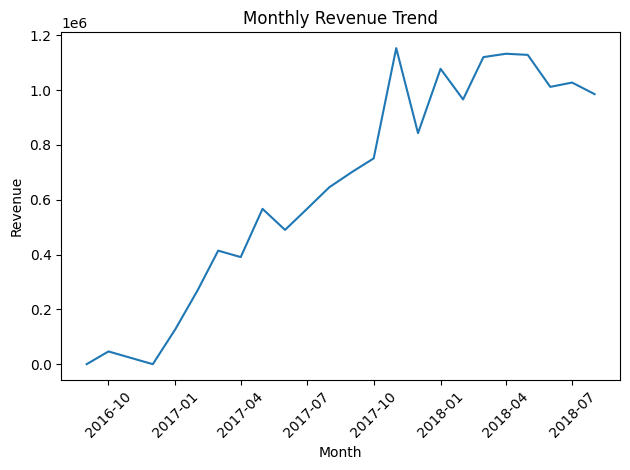

In [6]:
plt.figure()
plt.plot(monthly_revenue['purchase_month'], monthly_revenue['order_gmv'])

plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Revenue Trend Insight

Revenue scaled rapidly during 2017, indicating strong acquisition momentum.

Growth stabilized during 2018, suggesting potential market saturation or acquisition slowdown.

Future growth must increasingly depend on retention rather than pure customer acquisition.

# 5. Customer Retention & RFM Segmentation

To evaluate retention strength, revenue is aggregated at the customer level.

In [7]:
# Attach customer unique ID
orders_revenue = orders_revenue.merge(
    customers[['customer_id', 'customer_unique_id']],
    on='customer_id',
    how='left'
)

# Aggregate at customer level
customer_revenue = (
    orders_revenue
    .groupby('customer_unique_id')
    .agg({
        'order_id': 'nunique',
        'order_gmv': 'sum',
        'order_purchase_timestamp': 'max'
    })
    .reset_index()
)

customer_revenue.rename(columns={
    'order_id': 'total_orders',
    'order_gmv': 'total_revenue',
    'order_purchase_timestamp': 'last_purchase_date'
}, inplace=True)

In [8]:
customer_revenue[['total_orders', 'total_revenue']].describe()

,total_orders,total_revenue
count,93358.000000,93358.000000
mean,1.033420,165.168210
std,0.209097,226.292101
min,1.000000,9.590000
25%,1.000000,63.010000
50%,1.000000,107.780000
75%,1.000000,182.510000
max,15.000000,13664.080000


In [9]:
customer_revenue['is_repeat_customer'] = customer_revenue['total_orders'] > 1

total_customers = len(customer_revenue)
repeat_customers = customer_revenue['is_repeat_customer'].sum()
repeat_rate = repeat_customers / total_customers * 100

print(f"Total Customers: {total_customers:,}")
print(f"Repeat Customers: {repeat_customers:,}")
print(f"Repeat Purchase Rate: {repeat_rate:.2f}%")

Total Customers: 93,358
Repeat Customers: 2,801
Repeat Purchase Rate: 3.00%


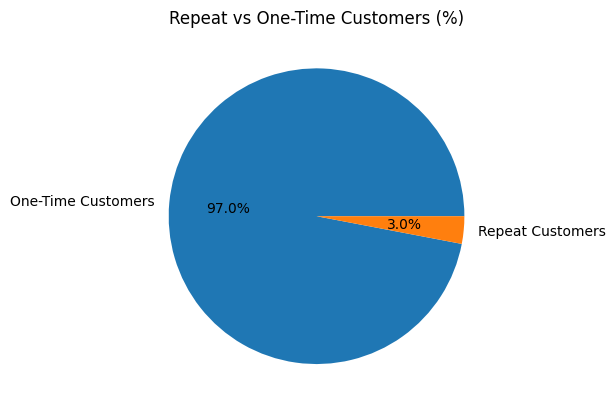

In [10]:
repeat_counts = customer_revenue['is_repeat_customer'].value_counts()
repeat_counts.index = ['One-Time Customers', 'Repeat Customers']

plt.figure()
plt.pie(repeat_counts, labels=repeat_counts.index, autopct='%1.1f%%')
plt.title('Repeat vs One-Time Customers (%)')
plt.show()

### Retention Insight

The repeat purchase rate is extremely low, with the majority of customers purchasing only once.

This indicates the marketplace operates primarily on acquisition rather than lifecycle engagement.

Long-term revenue sustainability depends heavily on continuous new customer acquisition.

## 5.1 RFM Segmentation Framework

RFM (Recency, Frequency, Monetary) analysis evaluates customer value using:

- Recency: How recently the customer purchased
- Frequency: How often they purchase
- Monetary: How much revenue they generate

This helps identify high-value, at-risk, and inactive customers.

In [11]:
# Reference date (latest purchase date)
reference_date = orders_revenue['order_purchase_timestamp'].max()

# Calculate recency in days
customer_revenue['recency_days'] = (
    reference_date - customer_revenue['last_purchase_date']
).dt.days

In [12]:
customer_revenue[['recency_days', 'total_orders', 'total_revenue']].describe()

,recency_days,total_orders,total_revenue
count,93358.000000,93358.000000,93358.000000
mean,236.941773,1.033420,165.168210
std,152.591453,0.209097,226.292101
min,0.000000,1.000000,9.590000
25%,113.000000,1.000000,63.010000
50%,218.000000,1.000000,107.780000
75%,345.000000,1.000000,182.510000
max,713.000000,15.000000,13664.080000


### RFM Distribution Insight

Frequency is heavily skewed toward single purchases.

Monetary values are right-skewed, indicating a small group of high-value customers.

This confirms structural retention weakness.

## 5.2 RFM Scoring

Customers are assigned quartile-based scores:

- Recency: Lower days = higher score
- Frequency: Higher purchases = higher score
- Monetary: Higher revenue = higher score

Scores range from 1 (low) to 4 (high).

In [13]:
# Recency Score (lower recency_days = better)
customer_revenue['R_score'] = pd.qcut(
    customer_revenue['recency_days'],
    4,
    labels=[4, 3, 2, 1]
)

# Frequency Score (higher frequency = better)
customer_revenue['F_score'] = pd.qcut(
    customer_revenue['total_orders'].rank(method='first'),
    4,
    labels=[1, 2, 3, 4]
)

# Monetary Score (higher revenue = better)
customer_revenue['M_score'] = pd.qcut(
    customer_revenue['total_revenue'],
    4,
    labels=[1, 2, 3, 4]
)

# Combine RFM score
customer_revenue['RFM_score'] = (
    customer_revenue['R_score'].astype(str) +
    customer_revenue['F_score'].astype(str) +
    customer_revenue['M_score'].astype(str)
)

## 5.3 Strategic Customer Segments

RFM scores are translated into business-relevant segments:

- Champions
- Loyal Customers
- At Risk
- Lost Customers
- New Customers
- Others

In [15]:
def segment_customer(row):
    if row['R_score'] == 4 and int(row['F_score']) >= 3 and int(row['M_score']) >= 3:
        return 'Champions'
    elif int(row['F_score']) >= 3 and int(row['M_score']) >= 3:
        return 'Loyal Customers'
    elif row['R_score'] <= 2 and int(row['F_score']) >= 2:
        return 'At Risk'
    elif row['R_score'] == 4 and int(row['F_score']) == 1:
        return 'New Customers'
    elif row['R_score'] == 1 and int(row['F_score']) == 1:
        return 'Lost Customers'
    else:
        return 'Others'

customer_revenue['segment'] = customer_revenue.apply(segment_customer, axis=1)

segment_counts = customer_revenue['segment'].value_counts()

segment_counts

segment
Others             34509
At Risk            23306
Loyal Customers    17704
Champions           6130
Lost Customers      5900
New Customers       5809
Name: count, dtype: int64

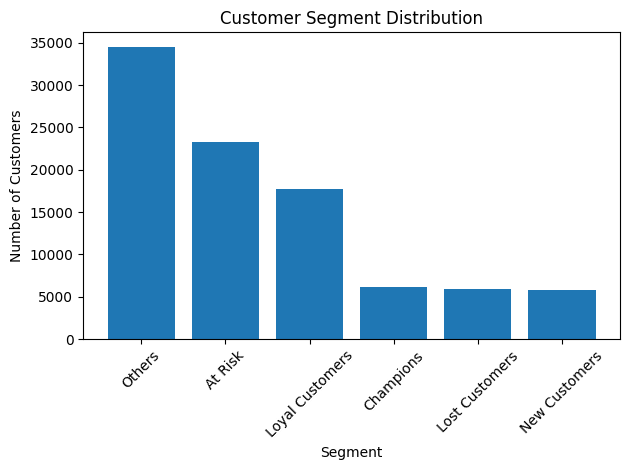

In [16]:
plt.figure()
plt.bar(segment_counts.index, segment_counts.values)

plt.xticks(rotation=45)
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

### Segmentation Insight

A large proportion of customers fall into "Others" and "At Risk" segments.

Champions represent a small fraction of the base, while Loyal Customers form the primary revenue backbone.

Retention optimization should prioritize At Risk and Loyal segments.

## 5.4 Revenue Contribution by Segment

Understanding which segments drive revenue helps prioritize retention strategy.

In [17]:
segment_revenue = (
    customer_revenue
    .groupby('segment')
    .agg({
        'customer_unique_id': 'count',
        'total_revenue': 'sum'
    })
    .reset_index()
)

segment_revenue.rename(columns={
    'customer_unique_id': 'customer_count'
}, inplace=True)

# Calculate revenue share
total_segment_revenue = segment_revenue['total_revenue'].sum()

segment_revenue['revenue_share_%'] = (
    segment_revenue['total_revenue'] / total_segment_revenue * 100
)

segment_revenue = segment_revenue.sort_values('total_revenue', ascending=False)

segment_revenue

,segment,customer_count,total_revenue,revenue_share_%
3,Loyal Customers,17704,4730067.92,30.675339
5,Others,34509,4467477.36,28.972392
0,At Risk,23306,2603920.87,16.886894
1,Champions,6130,1721218.13,11.162408
2,Lost Customers,5900,956847.63,6.205329
4,New Customers,5809,940241.84,6.097637


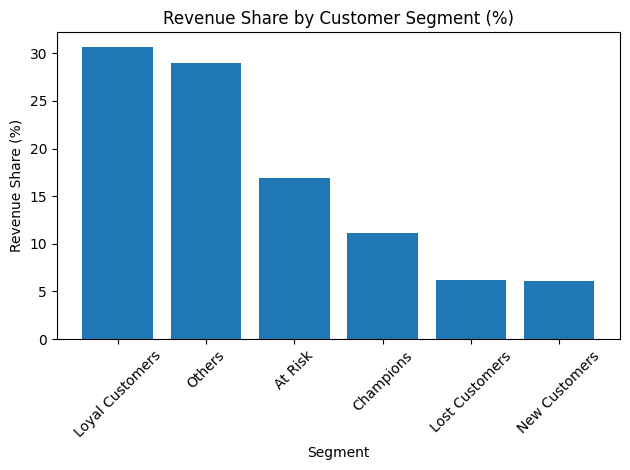

In [18]:
plt.figure()
plt.bar(segment_revenue['segment'], segment_revenue['revenue_share_%'])

plt.xticks(rotation=45)
plt.title('Revenue Share by Customer Segment (%)')
plt.xlabel('Segment')
plt.ylabel('Revenue Share (%)')

plt.tight_layout()
plt.show()

### Revenue Concentration Insight

Loyal Customers generate the largest revenue share, forming the core economic engine.

Champions contribute meaningfully but are not the dominant revenue source.

At Risk customers still represent significant revenue exposure, indicating churn risk.

# 6. Cohort Retention Analysis

Cohort analysis evaluates customer retention over time by grouping customers based on their first purchase month.

This helps measure behavioral decay and long-term engagement strength.

In [19]:
# Create purchase month
orders_revenue['purchase_month'] = orders_revenue['order_purchase_timestamp'].dt.to_period('M')

# Identify first purchase month per customer
customer_first_purchase = (
    orders_revenue
    .groupby('customer_unique_id')['purchase_month']
    .min()
    .reset_index()
)

customer_first_purchase.rename(columns={
    'purchase_month': 'cohort_month'
}, inplace=True)

In [20]:
orders_revenue = orders_revenue.merge(
    customer_first_purchase,
    on='customer_unique_id',
    how='left'
)

In [21]:
# Convert to timestamp
orders_revenue['purchase_month'] = orders_revenue['purchase_month'].dt.to_timestamp()
orders_revenue['cohort_month'] = orders_revenue['cohort_month'].dt.to_timestamp()

# Calculate cohort index (months since acquisition)
purchase_year = orders_revenue['purchase_month'].dt.year
purchase_month = orders_revenue['purchase_month'].dt.month

cohort_year = orders_revenue['cohort_month'].dt.year
cohort_month = orders_revenue['cohort_month'].dt.month

orders_revenue['cohort_index'] = (
    (purchase_year - cohort_year) * 12 +
    (purchase_month - cohort_month) + 1
)

In [22]:
cohort_data = (
    orders_revenue
    .groupby(['cohort_month', 'cohort_index'])['customer_unique_id']
    .nunique()
    .reset_index()
)

cohort_pivot = cohort_data.pivot_table(
    index='cohort_month',
    columns='cohort_index',
    values='customer_unique_id'
)

In [23]:
cohort_sizes = cohort_pivot.iloc[:, 0]

retention_matrix = cohort_pivot.divide(cohort_sizes, axis=0)

retention_matrix

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09-01,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-01,1.0,NaN,NaN,NaN,NaN,NaN,0.003817,NaN,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,NaN,0.003817,0.007634,0.007634
2016-12-01,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,1.0,0.002789,0.002789,0.001395,0.004184,0.001395,0.004184,0.001395,0.001395,NaN,0.004184,0.001395,0.006974,0.004184,0.001395,0.001395,0.002789,0.004184,0.001395,NaN
2017-02-01,1.0,0.001843,0.003071,0.001229,0.004300,0.001229,0.002457,0.001843,0.001229,0.001843,0.001229,0.003071,0.001229,0.001843,0.001229,0.000614,0.000614,0.001843,NaN,NaN
2017-03-01,1.0,0.004395,0.003596,0.003995,0.003596,0.001598,0.001598,0.003196,0.003196,0.000799,0.003596,0.001199,0.001998,0.001199,0.001598,0.002397,0.000799,0.001199,NaN,NaN
2017-04-01,1.0,0.006206,0.002216,0.001773,0.002660,0.002660,0.003546,0.003103,0.003103,0.001773,0.002660,0.000887,0.000443,0.000443,0.000887,0.000887,0.001330,NaN,NaN,NaN
2017-05-01,1.0,0.004636,0.004636,0.002898,0.002898,0.003187,0.004057,0.001449,0.002608,0.002608,0.002608,0.003477,0.002318,0.000290,0.001739,0.002028,NaN,NaN,NaN,NaN
2017-06-01,1.0,0.004939,0.003951,0.004281,0.002963,0.003951,0.003622,0.002305,0.001317,0.001976,0.002963,0.003622,0.001646,0.001646,0.002305,NaN,NaN,NaN,NaN,NaN


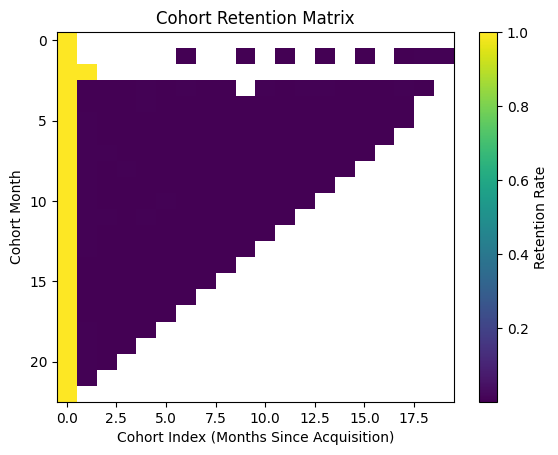

In [24]:
plt.figure()
plt.imshow(retention_matrix, aspect='auto')

plt.colorbar(label='Retention Rate')
plt.title('Cohort Retention Matrix')
plt.xlabel('Cohort Index (Months Since Acquisition)')
plt.ylabel('Cohort Month')

plt.show()

### Cohort Insight

Retention declines sharply after the first month.

Most cohorts show minimal sustained engagement beyond Month 2, confirming structural churn weakness.

Revenue growth is therefore dependent on continuous customer acquisition rather than lifecycle expansion.

# 7. Operational Performance & Customer Satisfaction

Delivery reliability directly impacts customer experience and brand perception.

We evaluate whether late deliveries influence review scores and retention.

In [25]:
orders_revenue['delivery_delay_days'] = (
    orders_revenue['order_delivered_customer_date'] -
    orders_revenue['order_estimated_delivery_date']
).dt.days

In [26]:
orders_with_reviews = orders_revenue.merge(
    reviews[['order_id', 'review_score']],
    on='order_id',
    how='left'
)

In [27]:
def delay_category(x):
    if x > 0:
        return 'Late'
    else:
        return 'On Time / Early'

orders_with_reviews['delivery_status'] = (
    orders_with_reviews['delivery_delay_days']
    .apply(delay_category)
)

In [28]:
orders_with_reviews.groupby('delivery_status')['review_score'].mean()

delivery_status
Late               2.271025
On Time / Early    4.289999
Name: review_score, dtype: float64

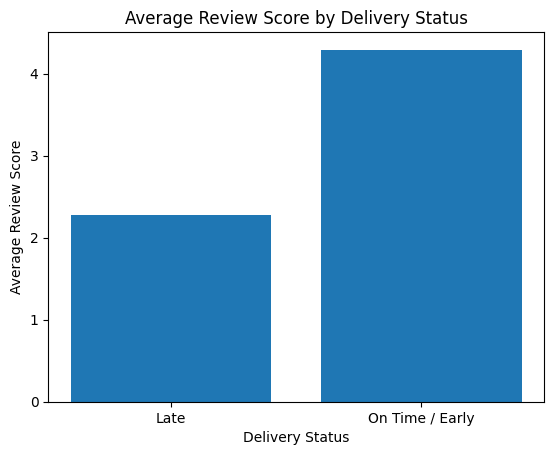

In [29]:
review_by_status = (
    orders_with_reviews
    .groupby('delivery_status')['review_score']
    .mean()
)

plt.figure()
plt.bar(review_by_status.index, review_by_status.values)

plt.title('Average Review Score by Delivery Status')
plt.xlabel('Delivery Status')
plt.ylabel('Average Review Score')

plt.show()

### Operational Insight

Late deliveries significantly reduce customer satisfaction.

Although late deliveries represent a small percentage of total orders, they disproportionately drive low ratings.

Maintaining delivery reliability is critical for protecting brand equity and retention.

# 8. Category Revenue & Concentration Analysis

Understanding which product categories drive revenue helps evaluate diversification, pricing power, and strategic focus areas.

In [31]:
# Merge category info
items_with_category = order_items.merge(
    products[['product_id', 'product_category_name']],
    on='product_id',
    how='left'
)

items_with_category = items_with_category.merge(
    category_translation,
    on='product_category_name',
    how='left'
)

# Keep delivered orders only
items_delivered = items_with_category.merge(
    orders_delivered[['order_id']],
    on='order_id',
    how='inner'
)

In [32]:
category_revenue = (
    items_delivered
    .groupby('product_category_name_english')
    .agg({
        'item_total': 'sum',
        'order_id': 'count'
    })
    .reset_index()
)

category_revenue.rename(columns={
    'item_total': 'total_revenue',
    'order_id': 'total_items_sold'
}, inplace=True)

category_revenue = category_revenue.sort_values(
    'total_revenue',
    ascending=False
).reset_index(drop=True)

category_revenue.head(10)

,product_category_name_english,total_revenue,total_items_sold
0,health_beauty,1412089.53,9465
1,watches_gifts,1264333.12,5859
2,bed_bath_table,1225209.26,10953
3,sports_leisure,1118256.91,8431
4,computers_accessories,1032723.77,7644
5,furniture_decor,880329.92,8160
6,housewares,758392.25,6795
7,cool_stuff,691680.89,3718
8,auto,669454.75,4140
9,garden_tools,567145.68,4268


In [33]:
total_marketplace_revenue = category_revenue['total_revenue'].sum()

category_revenue['revenue_share_%'] = (
    category_revenue['total_revenue'] / total_marketplace_revenue * 100
)

category_revenue['revenue_per_item'] = (
    category_revenue['total_revenue'] / category_revenue['total_items_sold']
)

category_revenue.head(10)

,product_category_name_english,total_revenue,total_items_sold,revenue_share_%,revenue_per_item
0,health_beauty,1412089.53,9465,9.280038,149.190653
1,watches_gifts,1264333.12,5859,8.309005,215.793330
2,bed_bath_table,1225209.26,10953,8.051889,111.860610
3,sports_leisure,1118256.91,8431,7.349015,132.636331
4,computers_accessories,1032723.77,7644,6.786904,135.102534
5,furniture_decor,880329.92,8160,5.785394,107.883569
6,housewares,758392.25,6795,4.984039,111.610338
7,cool_stuff,691680.89,3718,4.545622,186.035742
8,auto,669454.75,4140,4.399555,161.704046
9,garden_tools,567145.68,4268,3.727195,132.883243


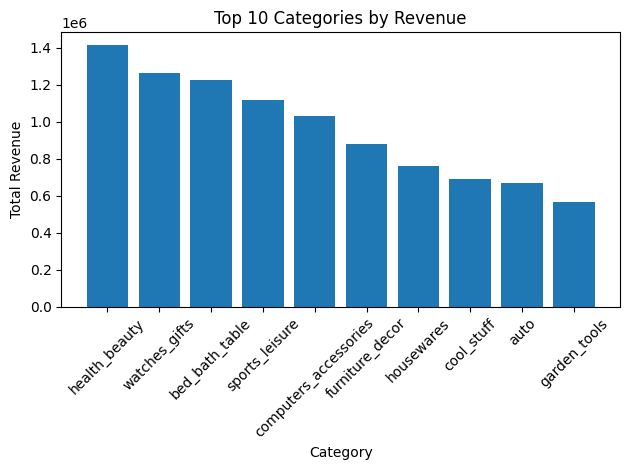

In [34]:
top10 = category_revenue.head(10)

plt.figure()
plt.bar(top10['product_category_name_english'], top10['total_revenue'])

plt.xticks(rotation=45)
plt.title('Top 10 Categories by Revenue')
plt.xlabel('Category')
plt.ylabel('Total Revenue')

plt.tight_layout()
plt.show()

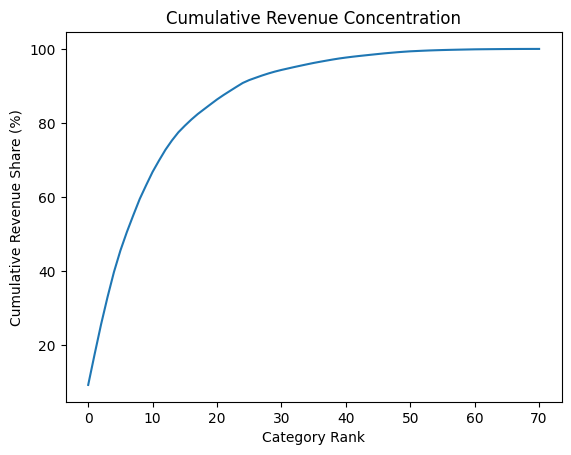

In [35]:
category_revenue['cumulative_revenue_%'] = (
    category_revenue['revenue_share_%'].cumsum()
)

plt.figure()
plt.plot(category_revenue['cumulative_revenue_%'])

plt.title('Cumulative Revenue Concentration')
plt.xlabel('Category Rank')
plt.ylabel('Cumulative Revenue Share (%)')

plt.show()

### Category Insight

Revenue is moderately diversified across product categories.

The top 5–7 categories generate approximately half of total marketplace revenue.

No single category dominates revenue, reducing concentration risk while preserving growth opportunities in core segments.

# 9. Strategic Recommendations

Based on revenue, retention, operational, and category analysis:

---

## 1. Strengthen Retention Strategy

- Implement post-purchase lifecycle campaigns.
- Develop loyalty incentives for Loyal and At Risk segments.
- Improve cross-selling and personalized recommendations.

Retention improvement is the highest-impact growth lever.

---

## 2. Protect Operational Reliability

- Maintain late delivery rate below 5%.
- Monitor carrier-level delay patterns.
- Investigate high-delay outliers.

Late deliveries have disproportionate impact on customer satisfaction.

---

## 3. Double Down on Core Revenue Categories

- Focus marketing efforts on top 5–7 categories.
- Optimize pricing strategy in high-ticket segments (e.g., watches_gifts).
- Expand high-performing categories strategically.

---

## 4. Reduce Acquisition Dependency

With repeat rate near 3%, revenue sustainability depends on continuous acquisition.

Retention development must become a strategic priority.

# 10. Project Summary

This engagement demonstrates:

- Structured data validation
- Revenue modeling (GMV construction)
- Time-series revenue trend analysis
- Customer segmentation using RFM
- Cohort retention modeling
- Operational impact assessment
- Category revenue concentration analysis
- Executive-level strategic interpretation

The analysis reflects real-world marketplace evaluation standards and business-focused data analytics methodology.